In [1]:
import pandas as pd
import numpy as np
import os

---

In [2]:
# fullContests = pd.read_csv('data/WorkingData.csv')
# durations = pd.read_csv('data/Durations.csv').drop(columns=['Unnamed: 0'])

In [3]:
# dirList = os.listdir("data/results/")
# kalmanResults = []
# for filename in dirList: #limit to .csv
#     if(filename[-4:] == '.csv'):
#         kalmanResults.append(pd.read_csv('data/results/'+filename).drop(columns=['Unnamed: 0']))
# resultsDF = pd.concat(kalmanResults)

In [4]:
# versions = resultsDF['label'].unique()
# print(versions)

In [5]:
# cids = resultsDF['ContestId'].unique()
# combinedObjs = []
# count = 0
# for cid in cids[:]:
#     obj = {'ContestId':cid}
#     count+=1
#     duration = durations[durations['ContestId']==cid].iloc[0].Duration
#     obj['Duration']=duration
#     for v in versions:
#         currC = resultsDF[resultsDF['ContestId']==cid]
#         AB = str(currC[currC['label']==v].Xf.iloc[0])[1:-1].split(', ')
        
#         obj['A'+v]=AB[0]
#         obj['B'+v]=AB[1]
#     if(count%10000==0):
#         print(str(count)+".../..."+str(len(cids)))
# #         print(obj)
#     combinedObjs.append(obj)

In [6]:
# combinedDF = pd.DataFrame(data = combinedObjs).set_index('ContestId')

In [7]:
# combinedDF.to_csv('data/QR_Results.csv')

---

In [8]:
# qrDF = pd.read_csv('data/QR_Results.csv').set_index('ContestId')
# qrDFCols = qrDF.columns
# dropList = []
# vNames = []
# for col in qrDFCols:
#     if("Pred" in col):
#         dropList.append(col)
#     if(col[0]=="A"):
#         vNames.append(col[1:])
# qrDF = qrDF.drop(columns = dropList)

In [9]:
# successDF = pd.read_csv('data/WorkedData.csv').set_index('ContestId')[['Success']]
# contestsDF = pd.read_csv('data/WorkingData.csv').set_index('ContestId')[['EntryFeeAmount', 'TotalPrizeAmount', 'MaxNumberPlayers']]
# contestsDF = pd.merge(contestsDF, successDF, on='ContestId', how='left')

In [10]:
# resultsDF = pd.merge(qrDF, contestsDF, on='ContestId', how='left').dropna()

---
### ROC Curves

In [11]:
import matplotlib.pyplot as plt

In [12]:
def getRates(df):
    results = []
    for c in df.columns.drop('Success'):
        label = c[len("Pred"):-len("_Scaled")]
        FP, TP = [], []
        FN, TN = [], []
        for i in range(0, 100):
            threshold=i/100.
            FP.append(len(df[(df[c]<threshold) & (df['Success']==1)])/len(df[df['Success']==1]))
            TP.append(len(df[(df[c]<threshold) & (df['Success']==0)])/len(df[df['Success']==0]))
            FN.append(len(df[(df[c]>threshold) & (df['Success']==0)])/len(df[df['Success']==0]))
            TN.append(len(df[(df[c]>threshold) & (df['Success']==1)])/len(df[df['Success']==1]))
        results.append({'Label':label, "TP":TP, "FP":FP, "TN":TN, "FN":FN})
    return results


In [ ]:
def rocCurve(results, positives = True, title = 'default'):
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 5)
    columns = ['TP', 'FP']
    if(not positives):
        columns = ['TN', 'FN']
    titleStr = "ROC for "
    for r in results:
        label = r['Label']
        TP, FP = r[columns[0]], r[columns[1]]
        titleStr = titleStr + " " + label
        ax.plot(FP, TP, alpha=0.4)
#     plt.plot(data)
    ax.set_xlabel(columns[1]+ ' Rate', fontsize=10)
    ax.set_ylabel(columns[0]+ ' Rate', fontsize='medium')  
    ax.set_xlim(xmax=1., xmin=0.)
    ax.set_ylim(ymax=1., ymin=0.)
    ax.grid(color='r', linestyle='-', linewidth=2)
    if(title != 'default'):
        fig.suptitle(title)
    else:
        fig.suptitle(titleStr)


In [16]:
# rates = getRates(qrPredsDF)
# maxedRates = getRates(maxedDF)
# avgRate = getRates(avgVal(maxedDF)[['AvgPred', 'Success']])

In [17]:
# positives = True
# rocCurve(rates, positives=positives, title = "ROC for raw")
# rocCurve(maxedRates, positives=positives, title = "ROC for scaledBackTo1")
# rocCurve(avgRate, positives=positives, title = "ROC for Avg")

---

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from ipywidgets import IntProgress
from IPython.display import display, HTML

In [19]:
#Samples DF for an approximate numnber of rows  (Needed for cutDF)
def cutDF(df, intendedNumber):
    df = df.sample(frac=intendedNumber/len(df), replace=True)
    return df

#Returns DF with ~50/50 split on specified binary column
def balanceDF(df, colName, numberOfEach = 0):
    successDF, failDF = df[df[colName] == 1], df[df[colName] == 0]
    if(numberOfEach == 0):
        maxContestsForBalance = min(len(successDF), len(failDF))
        numberOfEach = int(maxContestsForBalance*.1)
    combinedDF = pd.concat([cutDF(successDF, numberOfEach), cutDF(failDF, numberOfEach)])
    return combinedDF.sample(frac=1)

def splitTrainingTesting(df, percentTrain):
    df['is_train'] = np.random.uniform(0, 1, len(df)) <= percentTrain
    trainDF, testDF = df[df['is_train']==True], df[df['is_train']==False]
    df = df.drop(['is_train'], axis=1)
    trainDF = trainDF.drop(['is_train'], axis=1)
    testDF = testDF.drop(['is_train'], axis=1)
    return trainDF, testDF
def makeAndTrainClassifier(trainDF, classifierType): 
    clfFeatures = trainDF.columns.drop('Success')
    trainActual = trainDF['Success']
    clf = classifierType()
    clf.fit(trainDF[clfFeatures], trainActual.astype('int'))
    return clf
def classifierWrapper(trainDF, classifierType, balanced=False):
    if(balanced):
        trainDF = balanceDF(trainDF, 'Success')
    clf = makeAndTrainClassifier(trainDF, classifierType)
    columns = trainDF.columns
    return clf, columns

def getEnsembleResults(df, CLFs, threshold):
    localDF = df.copy(deep=True)
    preds = testEnsemble(localDF, CLFs)
    combinedPreds = combineCLFsPredictions(preds)
    return  localDF.assign(Prediction = makeDiscrete(combinedPreds, threshold))[['Success', 'Prediction']]

def testEnsemble(testDF, ensemble):
    testActual = testDF['Success']
    clfFeatures = testDF[testDF.columns.drop('Success')]
    preds = []
    for clf in ensemble:
        preds.append(clf['clf'].predict(testDF[clf['cols'].drop('Success')]))
    return preds
def makeDiscrete(array, threshold, isArray=False):
    dArr = []
    for v in array:
        value = v
        if(isArray):
            value = sum(v)/float(len(v))
        if(value < threshold):
            dArr.append(0.)
        else:
            dArr.append(1.)
    return dArr
def combineCLFsPredictions(preds):
    numContests = len(preds)
    newPreds = []
    for c in range(0, len(preds[0])):
        predSum = 0
        for CLF in range(0, len(preds)):
            singlePred = preds[CLF][c]
            predSum += singlePred
        newPreds.append(predSum/(float(numContests)))
    return newPreds

accuracies = []
def makeEnsembleWithMinAcc(testDF, testActual, numClassifiers, minAcc, minLogThreshold = 1.0):
    goodCLFs = []
    genBar = IntProgress(min=0, max=numClassifiers, description='Collecting Accurate CLFs:')
    display(genBar)
    for i in range(0, numClassifiers):
        acc = 0
        clf, cols = 'err', 'err'    
        while acc < minAcc:
            clf, cols = classifierWrapper(trainDF, RandomForestClassifier, balanced=True)
            pred = clf.predict(testDF[cols.drop('Success')])
            acc = accuracy_score(testActual.astype('int'), pred)
        if(acc > minLogThreshold):
            print("#"+str(len(goodCLFs)-1)+":", acc)
        accuracies.append(acc)
        goodCLFs.append({'clf': clf, 'cols':cols})
        genBar.value += 1
    return goodCLFs
def trainEnsemble(trainDF, numClassifiers = 100, classifierType = RandomForestClassifier, balanced = True):
    if classifierType == 'random':
        classifierType = getRandomClassifier()
    trainBar = IntProgress(min=0, max=numClassifiers, description='Training:')
    display(trainBar)
    clfs = []
    for c in range(0, numClassifiers):
        tDF = trainDF.copy()
        clf, cols = classifierWrapper(tDF, classifierType, balanced, numColumns=10)
        clfs.append({'clf': clf, 'cols':cols})
        trainBar.value += 1
    return clfs


In [210]:
# def rocCurve(results, positives = True, title = 'default'):
#     fig, ax = plt.subplots()
#     fig.set_size_inches(5, 5)
#     columns = ['TP', 'FP']
#     if(not positives):
#         columns = ['TN', 'FN']
#     titleStr = "ROC for "
#     for r in results:
#         label = r['Label']
#         TP, FP = r[columns[0]], r[columns[1]]
#         titleStr = titleStr + " " + label
#         ax.plot(FP, TP, alpha=0.4)
# #     plt.plot(data)
#     ax.set_xlabel(columns[1]+ ' Rate', fontsize=10)
#     ax.set_ylabel(columns[0]+ ' Rate', fontsize='medium')  
#     ax.set_xlim(xmax=1., xmin=0.)
#     ax.set_ylim(ymax=1., ymin=0.)
#     ax.grid(color='r', linestyle='-', linewidth=2)
#     if(title != 'default'):
#         fig.suptitle(title)
#     else:
#         fig.suptitle(titleStr)



In [103]:

def rocObj(label, FP='-', TP='-', FN='-', TN='-'):
    obj = {'Label':label }
    if(not(FP is '-')):
        obj['FP'] = FP
    if(not(FN is '-')):
        obj['FN'] = FN
    if(not(TP is '-')):
        obj['TP'] = TP
    if(not(TN is '-')):
        obj['TN'] = TN
    return obj
def maxAtN(df, dropCols = ['Success'], N = 1.):
    for c in df.columns.drop(dropCols):
        df[c].where(df[c] <= N, N) 
    return df
def avgVal(df, dropCols = ['Success']):
    df['AvgPred'] = df.drop(columns=dropCols).mean(axis=1)
    return df
def getRates(df,label='nonCLF'):
    results = []
    for c in df.columns.drop('Success'):
#         label = c[len("Pred"):-len("_Scaled")]
        FP, TP = [], []
        FN, TN = [], []
        for i in range(0, 100):
            threshold=i/100.
            FP.append(len(df[(df[c]<threshold) & (df['Success']==1)])/len(df[df['Success']==1]))
            TP.append(len(df[(df[c]<threshold) & (df['Success']==0)])/len(df[df['Success']==0]))
            FN.append(len(df[(df[c]>threshold) & (df['Success']==0)])/len(df[df['Success']==0]))
            TN.append(len(df[(df[c]>threshold) & (df['Success']==1)])/len(df[df['Success']==1]))
        results.append(rocObj(label, TP=TP, FP=FP, TN=TN, FN=FN))
    return results
def getRatesCLF(df, CLFS, label='CLF'):
    results = []
    FP, TP = [], []
    FN, TN = [], []
    trainBar = IntProgress(min=0, max=100, description='Testing Thresholds:')
    display(trainBar)
    for i in range(0, 100)[:]:
        threshold=i/100.
        resultsDF = getEnsembleResults(df, CLFS, threshold)
        FP.append(len(resultsDF[(resultsDF['Prediction']==0) & (resultsDF['Success']==1)])/len(resultsDF[resultsDF['Success']==1]))
        TP.append(len(resultsDF[(resultsDF['Prediction']==0) & (resultsDF['Success']==0)])/len(resultsDF[resultsDF['Success']==0]))
        FN.append(len(resultsDF[(resultsDF['Prediction']==1) & (resultsDF['Success']==0)])/len(resultsDF[resultsDF['Success']==0]))
        TN.append(len(resultsDF[(resultsDF['Prediction']==1) & (resultsDF['Success']==1)])/len(resultsDF[resultsDF['Success']==1]))
        trainBar.value+=1
    results.append(rocObj(label, TP=TP, FP=FP, TN=TN, FN=FN))
    return results

## Analysis

In [47]:
contests = pd.read_csv('data/WorkedData.csv')
qrPredsDF = pd.read_csv('data/QR_Preds.csv').set_index('ContestId').drop(columns=['is_train'])
print("Num QR Data Points: 46000 -->", len(qrPredsDF))

Num QR Data Points: 46000 --> 33473


##### Avg QR Rates

In [104]:
maxedDF = maxAtN(qrPredsDF, N=1.)
avgRate = getRates(avgVal(maxedDF)[['AvgPred', 'Success']], label='Avg Kalman Pred')

##### Kalman Ensemble Rates

In [58]:
trainDF, testDF = splitTrainingTesting(maxedDF, .75)
CLFS = makeEnsembleWithMinAcc(trainDF, trainDF['Success'].astype('int'), 20, .6)
kalmanEnsRates = getRatesCLF(testDF, CLFS, label="Kalman Ensemble")

IntProgress(value=0, description='Collecting Accurate CLFs:', max=20)

IntProgress(value=0, description='Testing Thresholds:')

##### Contests Ensemble Rates

In [60]:
trainDF, testDF = splitTrainingTesting(contests.drop(columns=['FillGapDollars', 'TrueLoss']), .75)
CLFS = makeEnsembleWithMinAcc(trainDF, trainDF['Success'].astype('int'), 20, .6)
contestEnsRates = getRatesCLF(testDF, CLFS, label="A Priori Ensemble")

IntProgress(value=0, description='Collecting Accurate CLFs:', max=20)

IntProgress(value=0, description='Testing Thresholds:')

##### Full Ensemble Rates

In [61]:
#Success dropped since maxedDF also has it
mergedDF = pd.merge(maxedDF, contests.drop(columns=['Success', 'FillGapDollars', 'TrueLoss']), on='ContestId', how='left').set_index('ContestId')

In [62]:
trainDF, testDF = splitTrainingTesting(mergedDF, .75)
CLFS = makeEnsembleWithMinAcc(trainDF, trainDF['Success'].astype('int'), 20, .6)
fullEnsRates = getRatesCLF(testDF, CLFS, label="Full Ensemble")

IntProgress(value=0, description='Collecting Accurate CLFs:', max=20)

IntProgress(value=0, description='Testing Thresholds:')

##### Brown Rates

In [167]:
brownDF = pd.read_csv('data/browncurve.csv', header=None, names=['FP', 'TP'])
brownRates = [rocObj('Brown Curve', FP=brownDF['FP'].values, TP=brownDF['TP'].values)]

#### TP=FP^3

In [154]:
TP, FP = [], []
for i in range(0, 100):
    x = i/100.
    y = x*x*x*x
    TP.append(1-y)
    FP.append(1-x)
FP3 = [rocObj('x^3', FP=FP, TP=TP)]

### Actually plot

In [161]:
def plotRocs(rocObjArray):
    fig = plt.figure()
    fig.set_size_inches(10, 10)

    ax = fig.add_subplot(1,1,1)
    
    for rocObj in rocObjArray:
        label = rocObj[0]['Label']
        FP, TP = rocObj[0]['FP'], rocObj[0]['TP']
        ax.plot(FP,TP,'-' ,label = label,zorder = -32, alpha=.5)

    handles, labels = ax.get_legend_handles_labels()
    display = (0,71)
    ax.set_xlabel('FP Rate')
    ax.set_xlim(0,1)
    ax.set_ylabel('TP Rate')
    ax.set_ylim(0,1)
    ax.grid(color='black', linestyle='-', linewidth=1, alpha=.5)
    ax.set_title('ROC Curve Compliation')
    ax.legend()

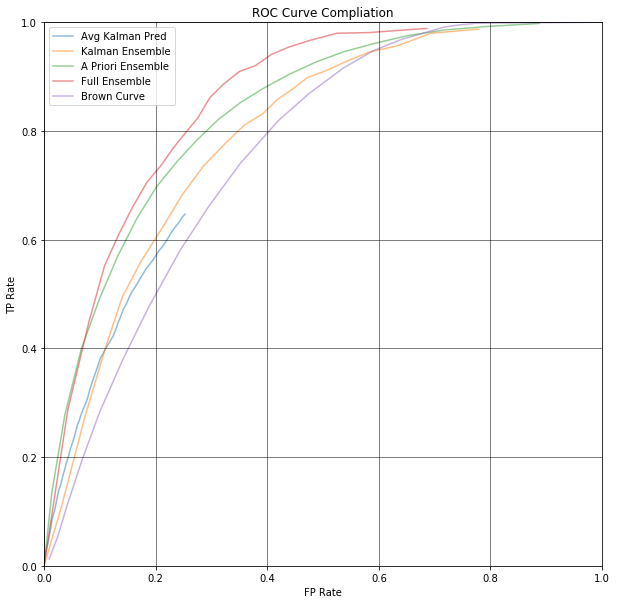

In [168]:
rocObjArray = [avgRate, kalmanEnsRates, contestEnsRates, fullEnsRates, brownRates]
plotRocs(rocObjArray)